<a href="https://colab.research.google.com/github/pilipandr770/-/blob/main/%D0%9A%D0%BE%D0%BF%D1%96%D1%8F_%D0%B7%D0%B0%D0%BF%D0%B8%D1%81%D0%BD%D0%B8%D0%BA%D0%B0_%22%D0%94%D0%B0%D1%82%D0%B0_%D1%8F%D1%85%D1%83_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import pandas as pd

# === НАСТРОЙКИ ===
TICKER = "BTC-EUR"
TIMEFRAMES = {
    "15m": "60d",
    "30m": "60d",
    "1h": "1y",
    "1d": "max"
}

def fetch_data(ticker, tf_dict):
    frames = {}
    print(f"\n📡 Получаем данные по: {ticker}")
    for tf, period in tf_dict.items():
        df = yf.download(ticker, interval=tf, period=period, progress=False)
        if df.empty:
            print(f"  └─ ✗ {tf}: нет данных")
            continue
        df.reset_index(inplace=True)
        df["tf"] = tf
        frames[tf] = df
        print(f"  └─ ✓ {tf}: {len(df)} строк")
    return frames

def print_samples(frames):
    print("\n📌 Примеры:")
    for tf, df in frames.items():
        print(f"\n=== {tf.upper()} ===")
        print(df.head())

frames = fetch_data(TICKER, TIMEFRAMES)
print_samples(frames)



📡 Получаем данные по: BTC-EUR
YF.download() has changed argument auto_adjust default to True
  └─ ✓ 15m: 5738 строк
  └─ ✓ 30m: 2869 строк
  └─ ✓ 1h: 8761 строк
  └─ ✓ 1d: 3855 строк

📌 Примеры:

=== 15M ===
Price                   Datetime         Close          High           Low  \
Ticker                                 BTC-EUR       BTC-EUR       BTC-EUR   
0      2025-02-06 00:00:00+00:00  92956.218750  92971.609375  92800.765625   
1      2025-02-06 00:15:00+00:00  92961.781250  93173.921875  92961.781250   
2      2025-02-06 00:30:00+00:00  93073.546875  93198.203125  92894.062500   
3      2025-02-06 00:45:00+00:00  93164.265625  93164.265625  93003.187500   
4      2025-02-06 01:00:00+00:00  93308.234375  93346.031250  92981.007812   

Price           Open     Volume   tf  
Ticker       BTC-EUR    BTC-EUR       
0       92838.265625  134029312  15m  
1       93000.093750  722030592  15m  
2       92933.570312  685916160  15m  
3       93106.656250  674971648  15m  
4       93

In [ ]:
# Нормализация всех фреймов перед индикаторами
def normalize_columns(frames):
    for tf, df in frames.items():
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(1)  # Берём нижний уровень названия
        df.columns = ["Datetime", "Close", "High", "Low", "Open", "Volume", "tf"]
        frames[tf] = df
    return frames

frames = normalize_columns(frames)


In [ ]:
!pip install ta

import ta

def calculate_indicators(frames):
    all_dfs = []
    for tf, df in frames.items():
        df = df.copy()
        df.sort_values("Datetime", inplace=True)
        prefix = f"{tf}_"

        # Индикаторы
        df[prefix + "rsi"] = ta.momentum.RSIIndicator(close=df['Close']).rsi()
        df[prefix + "ema12"] = ta.trend.EMAIndicator(close=df['Close'], window=12).ema_indicator()
        df[prefix + "ema26"] = ta.trend.EMAIndicator(close=df['Close'], window=26).ema_indicator()
        df[prefix + "ma7"] = df['Close'].rolling(window=7).mean()
        df[prefix + "ma25"] = df['Close'].rolling(window=25).mean()

        macd = ta.trend.MACD(close=df['Close'])
        df[prefix + 'macd'] = macd.macd()
        df[prefix + 'macd_signal'] = macd.macd_signal()

        bb = ta.volatility.BollingerBands(close=df['Close'])
        df[prefix + 'bb_high'] = bb.bollinger_hband()
        df[prefix + 'bb_low'] = bb.bollinger_lband()
        df[prefix + 'bb_width'] = bb.bollinger_wband()

        df[prefix + 'obv'] = ta.volume.OnBalanceVolumeIndicator(close=df['Close'], volume=df['Volume']).on_balance_volume()
        df[prefix + 'atr'] = ta.volatility.AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close']).average_true_range()
        df[prefix + 'volume_rolling'] = df['Volume'].rolling(window=5).mean()

        # Чистим NaN по индикаторам (внутри каждого таймфрейма)
        indicators = [col for col in df.columns if col.startswith(prefix)]
        df = df.dropna(subset=indicators)
        all_dfs.append(df)

    result_df = pd.concat(all_dfs).reset_index(drop=True)
    result_df.to_csv("/content/BTC_EUR_features_clean.csv", index=False)
    print(f"\n✅ Индикаторы рассчитаны. Готово строк: {len(result_df)}")
    return result_df

df_features = calculate_indicators(frames)
df_features.head()


  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=4bbf1ab10920978dfe880b04176fcf3a05783609eb08fefbef0ed849a77c2db0
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta

✅ Индикаторы рассчитаны. Готово строк: 21091


,Datetime,Close,High,Low,Open,Volume,tf,15m_rsi,15m_ema12,15m_ema26,...,1d_ma7,1d_ma25,1d_macd,1d_macd_signal,1d_bb_high,1d_bb_low,1d_bb_width,1d_obv,1d_atr,1d_volume_rolling
0,2025-02-06 08:15:00+00:00,94637.539062,94709.195312,94598.093750,94673.507812,206950400,15m,72.703769,94466.812644,94152.959499,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-02-06 08:30:00+00:00,94666.671875,94725.250000,94604.390625,94685.625000,530202624,15m,73.401977,94497.560218,94191.012267,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-02-06 08:45:00+00:00,94734.796875,94814.085938,94648.171875,94661.273438,676114432,15m,75.011619,94534.058165,94231.292609,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025-02-06 09:00:00+00:00,95202.726562,95202.726562,94728.757812,94728.757812,610758656,15m,82.738658,94636.930227,94303.250679,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-02-06 09:15:00+00:00,95083.562500,95314.476562,95083.562500,95215.460938,626098176,15m,76.270495,94705.642884,94361.051555,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Mount Google Drive to access the save path.
from google.colab import drive
drive.mount('/content/drive')

# Create the 'bot_data' directory if it doesn't exist
import os
if not os.path.exists('/content/drive/MyDrive/bot_data'):
    os.makedirs('/content/drive/MyDrive/bot_data')

# Rest of your code...
df_features.to_csv('/content/drive/MyDrive/bot_data/BTC_EUR_features_clean.csv', index=False)
print("📦 Файл сохранён: BTC_EUR_features_clean.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📦 Файл сохранён: BTC_EUR_features_clean.csv


In [ ]:
# Mount Google Drive to access the save path.
from google.colab import drive
drive.mount('/content/drive')

# Rest of your code...
df_features.to_csv('/content/drive/MyDrive/bot_data/BTC_EUR_features_clean.csv', index=False)
print("📦 Файл сохранён: BTC_EUR_features_clean.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📦 Файл сохранён: BTC_EUR_features_clean.csv


In [ ]:
# Сохраняем датафрейм с индикаторами в CSV
df_features.to_csv('/content/drive/MyDrive/bot_data/BTC_EUR_features_clean.csv', index=False)

print("📦 Файл сохранён: BTC_EUR_features_clean.csv")


📦 Файл сохранён: BTC_EUR_features_clean.csv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# === 1. Загрузка фичейного датафрейма ===
df = pd.read_csv('/content/drive/MyDrive/bot_data/BTC_EUR_features_clean.csv')

# === 2. Параметры оценки сигнала ===
FUTURE_PERIOD = 4  # Сколько свечей вперёд смотреть (например, 4 свечи по 15m = 1 час)
PROFIT_THRESHOLD = 0.005  # +0.5% от текущей цены — считаем успехом
LOSS_THRESHOLD = -0.005   # -0.5% — считаем неудачей

# === 3. Готовим вспомогательные колонки ===
df.sort_values('Datetime', inplace=True)
df = df.reset_index(drop=True)

# Считаем "будущее" изменение цены через N свечей
df['future_close'] = df['Close'].shift(-FUTURE_PERIOD)

# Расчёт дельты (в процентах)
df['pct_change'] = (df['future_close'] - df['Close']) / df['Close']

# === 4. Генерация таргета на основе порогов ===
def label_trade_outcome(change):
    if change >= PROFIT_THRESHOLD:
        return 1   # Сигнал успешный (прибыльный)
    elif change <= LOSS_THRESHOLD:
        return 0   # Сигнал неуспешный
    else:
        return None  # Неопределённый — исключаем

df['target'] = df['pct_change'].apply(label_trade_outcome)

# === 5. Очистка от пустых target (те, что в серой зоне между loss/profit)
df = df.dropna(subset=['target'])
df['target'] = df['target'].astype(int)  # Явно приводим к int

# === 6. Убираем вспомогательные колонки (если нужно)
df.drop(['future_close', 'pct_change'], axis=1, inplace=True)

# === 7. Сохраняем результат
df.to_csv('/content/drive/MyDrive/bot_data/BTC_EUR_with_target.csv', index=False)
print(f"✅ Цель добавлена. Строк для обучения: {len(df)}")
print(df[['Datetime', 'Close', 'target']].head())


✅ Цель добавлена. Строк для обучения: 8180
              Datetime       Close  target
0  2014-10-20 00:00:00  299.214539       0
1  2014-10-21 00:00:00  304.023773       0
2  2014-10-22 00:00:00  303.107330       0
3  2014-10-23 00:00:00  283.355988       0
4  2014-10-24 00:00:00  282.829529       0


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# === 1. Загружаем данные ===
df = pd.read_csv('/content/drive/MyDrive/bot_data/BTC_EUR_with_target.csv')

# === 2. Отделяем фичи от целевой переменной ===
# Удаляем служебные колонки
X = df.drop(columns=['Datetime', 'tf', 'target'])
y = df['target']

# === 3. Разделение на train/test ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === 4. Обучаем модель ===
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# === 5. Предсказания и отчёт ===
y_pred = model.predict(X_test)

print("🎯 Classification Report:")
print(classification_report(y_test, y_pred))

print("📉 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# === 6. Сохраняем модель
joblib.dump(model, '/content/drive/MyDrive/bot_data/rf_model.pkl')
print("✅ Модель сохранена: rf_model.pkl")


🎯 Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.59      0.63       779
           1       0.67      0.75      0.70       857

    accuracy                           0.67      1636
   macro avg       0.67      0.67      0.67      1636
weighted avg       0.67      0.67      0.67      1636

📉 Confusion Matrix:
[[458 321]
 [216 641]]
✅ Модель сохранена: rf_model.pkl


In [ ]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt

# Загружаем обучающую выборку и модель
df = pd.read_csv('/content/drive/MyDrive/bot_data/BTC_EUR_with_target.csv')
model = joblib.load('/content/drive/MyDrive/bot_data/rf_model.pkl')

# Отделяем фичи и цель
X = df.drop(columns=['Datetime', 'tf', 'target'])
y = df['target']


           feature  importance
0            Close    0.051272
1             High    0.049638
2              Low    0.047236
3             Open    0.047064
4           Volume    0.035660
44          1d_rsi    0.031608
41          1h_obv    0.030287
55          1d_atr    0.026280
50  1d_macd_signal    0.025492
35         1h_ma25    0.024479
42          1h_atr    0.023289
36         1h_macd    0.023142
53     1d_bb_width    0.023128
39       1h_bb_low    0.023033
54          1d_obv    0.022067
33        1h_ema26    0.021700
37  1h_macd_signal    0.021688
52       1d_bb_low    0.021485
46        1d_ema26    0.021213
38      1h_bb_high    0.020899


<ipython-input-20-6aaaf16be876>:23: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


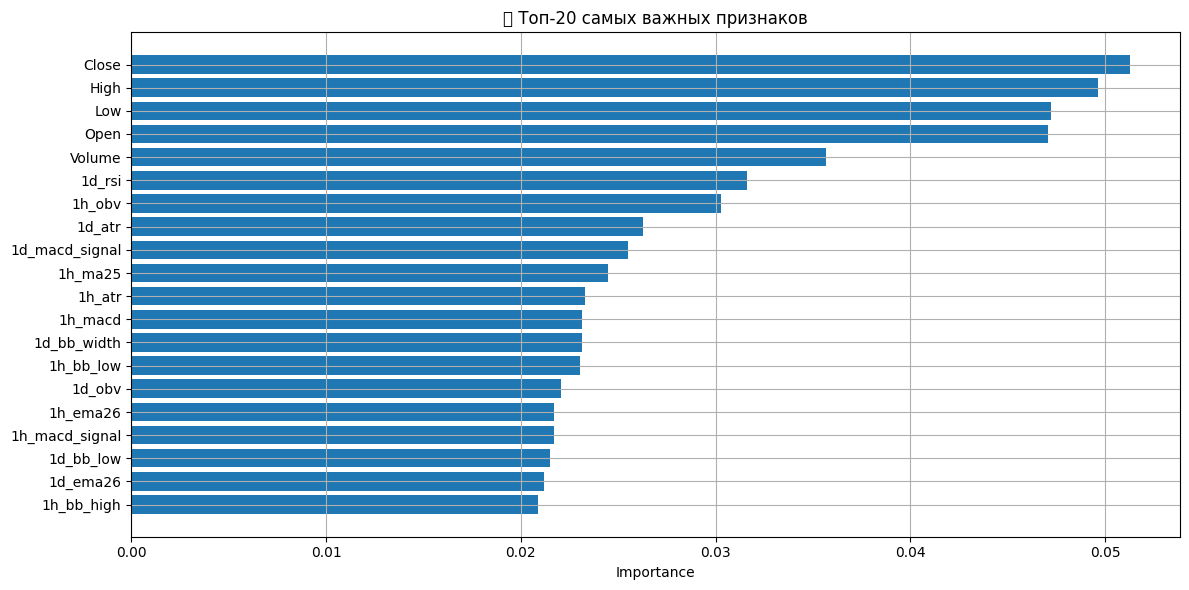

In [ ]:
import numpy as np

# Получаем важность фичей
importances = model.feature_importances_
feature_names = X.columns

# Объединяем в таблицу
feat_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Смотрим топ-20
print(feat_df.head(20))

# Строим график
plt.figure(figsize=(12, 6))
plt.barh(feat_df['feature'].head(20), feat_df['importance'].head(20))
plt.gca().invert_yaxis()
plt.title("🔥 Топ-20 самых важных признаков")
plt.xlabel("Importance")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Ос
# Оставим только признаки с важностью > 0.005
selected_features = feat_df[feat_df['importance'] > 0.005]['feature'].tolist()

# Новый X
X_filtered = X[selected_features]
# Ос
# Оставим только признаки с важностью > 0.005
selected_features = feat_df[feat_df['importance'] > 0.005]['feature'].tolist()

# Новый X
X_filtered = X[selected_features]
print(f"🎯 Оставлено признаков: {len(selected_features)}")

# Оставим только признаки с важностью > 0.005
selected_features = feat_df[feat_df['importance'] > 0.005]['feature'].tolist()

# Новый X
X_filtered = X[selected_features]
print(f"🎯 Оставлено признаков: {len(selected_features)}")
# Новый X
X_filtered = X[selected_features]
print(f"🎯 Оставлено признаков: {len(selected_features)}")


🎯 Оставлено признаков: 44
🎯 Оставлено признаков: 44
🎯 Оставлено признаков: 44


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Сплит
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y, test_size=0.2, random_state=42, stratify=y
)

# Обучение
model_retrained = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model_retrained.fit(X_train, y_train)

# Предсказания
y_pred = model_retrained.predict(X_test)

# Метрики
print("🎯 Новый Classification Report:")
print(classification_report(y_test, y_pred))

print("📉 Новый Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Сохраняем
joblib.dump(model_retrained, '/content/drive/MyDrive/bot_data/rf_model_filtered.pkl')
print("✅ Новая модель сохранена: rf_model_filtered.pkl")


🎯 Новый Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.59      0.63       779
           1       0.66      0.73      0.69       857

    accuracy                           0.66      1636
   macro avg       0.66      0.66      0.66      1636
weighted avg       0.66      0.66      0.66      1636

📉 Новый Confusion Matrix:
[[461 318]
 [233 624]]
✅ Новая модель сохранена: rf_model_filtered.pkl


In [ ]:
import yfinance as yf
import pandas as pd
import os

# === НАСТРОЙКИ ===
TICKER = "BTC-EUR"
INTERVALS = ["1m", "5m"]
PERIOD = "7d"  # максимум, что даёт yfinance для 1m

SAVE_PATH = "/content/drive/MyDrive/bot_data"
os.makedirs(SAVE_PATH, exist_ok=True)

def fetch_fast_data(ticker, intervals, period):
    all_data = []
    for tf in intervals:
        print(f"📥 Получаем {ticker} — {tf}")
        df = yf.download(ticker, interval=tf, period=period, progress=False)
        if not df.empty:
            df.reset_index(inplace=True)
            df["tf"] = tf
            all_data.append(df)
        else:
            print(f"⚠️ Данные пустые для {tf}")
    return all_data

frames = fetch_fast_data(TICKER, INTERVALS, PERIOD)

# Сохраняем отдельно
for df in frames:
    tf = df["tf"].iloc[0]
    file = os.path.join(SAVE_PATH, f"BTC_EUR_fast_{tf}.csv")
    df.to_csv(file, index=False)
    print(f"✅ Сохранено: {file}")


📥 Получаем BTC-EUR — 1m
📥 Получаем BTC-EUR — 5m
✅ Сохранено: /content/drive/MyDrive/bot_data/BTC_EUR_fast_1m.csv
✅ Сохранено: /content/drive/MyDrive/bot_data/BTC_EUR_fast_5m.csv


In [ ]:
import pandas as pd
import os

BASE_DIR = "/content/drive/MyDrive/bot_data"

for tf in ["1m", "5m"]:
    path = os.path.join(BASE_DIR, f"BTC_EUR_fast_{tf}.csv")
    df = pd.read_csv(path)

    # 🧼 Очистка многоуровневых названий
    df.columns = [col.split('.')[-1] if isinstance(col, str) else col for col in df.columns]
    df.columns = [col.strip().replace(" ", "_") for col in df.columns]

    # 🧠 Приводим к нормальному виду типы данных
    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df["Datetime"] = pd.to_datetime(df["Datetime"], errors='coerce')
    df["tf"] = tf

    # Сохраняем обратно
    cleaned_path = os.path.join(BASE_DIR, f"BTC_EUR_fast_cleaned_{tf}.csv")
    df.to_csv(cleaned_path, index=False)
    print(f"✅ Очищено и сохранено: {cleaned_path}")


✅ Очищено и сохранено: /content/drive/MyDrive/bot_data/BTC_EUR_fast_cleaned_1m.csv
✅ Очищено и сохранено: /content/drive/MyDrive/bot_data/BTC_EUR_fast_cleaned_5m.csv


In [ ]:
import pandas as pd
import ta
import os

# === ПУТИ ===
BASE_DIR = "/content/drive/MyDrive/bot_data"
OUTPUT_FILE = os.path.join(BASE_DIR, "BTC_EUR_fast_features_cleaned.csv")

# === ЧТЕНИЕ CSV (предварительно очищенные по колонкам!) ===
dfs = []
for tf in ["1m", "5m"]:
    path = os.path.join(BASE_DIR, f"BTC_EUR_fast_cleaned_{tf}.csv")
    df = pd.read_csv(path)

    # Приводим типы к float, а дату — к datetime
    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df["Datetime"] = pd.to_datetime(df["Datetime"], errors='coerce')
    df["tf"] = tf
    dfs.append(df)

# Объединяем
df = pd.concat(dfs, ignore_index=True)
df.sort_values("Datetime", inplace=True)

# === ИНДИКАТОРЫ ===
result_frames = []

for tf in df["tf"].unique():
    sub = df[df["tf"] == tf].copy()

    # Удаляем строки, где нет базовых значений
    sub = sub.dropna(subset=["Close", "Open", "High", "Low", "Volume"]).copy()

    # Индикаторы
    sub[f"{tf}_rsi"] = ta.momentum.RSIIndicator(close=sub["Close"]).rsi()
    sub[f"{tf}_ema12"] = ta.trend.EMAIndicator(close=sub["Close"], window=12).ema_indicator()
    sub[f"{tf}_ema26"] = ta.trend.EMAIndicator(close=sub["Close"], window=26).ema_indicator()

    macd = ta.trend.MACD(close=sub["Close"])
    sub[f"{tf}_macd"] = macd.macd()
    sub[f"{tf}_macd_signal"] = macd.macd_signal()

    bb = ta.volatility.BollingerBands(close=sub["Close"])
    sub[f"{tf}_bb_high"] = bb.bollinger_hband()
    sub[f"{tf}_bb_low"] = bb.bollinger_lband()
    sub[f"{tf}_bb_width"] = bb.bollinger_wband()

    sub[f"{tf}_atr"] = ta.volatility.AverageTrueRange(
        high=sub["High"], low=sub["Low"], close=sub["Close"]
    ).average_true_range()

    sub[f"{tf}_obv"] = ta.volume.OnBalanceVolumeIndicator(
        close=sub["Close"], volume=sub["Volume"]
    ).on_balance_volume()

    sub[f"{tf}_volume_rolling"] = sub["Volume"].rolling(window=10).sum()

    # Удаляем строки с NaN в СВОИХ индикаторах
    sub.dropna(inplace=True)

    result_frames.append(sub)

# === ФИНАЛ ===
df_feat = pd.concat(result_frames, ignore_index=True)
df_feat.to_csv(OUTPUT_FILE, index=False)

print(f"✅ Индикаторы рассчитаны и сохранены: {OUTPUT_FILE}")
print(f"🧮 Строк всего: {len(df_feat)}")
print(df_feat.head(3))


✅ Индикаторы рассчитаны и сохранены: /content/drive/MyDrive/bot_data/BTC_EUR_fast_features_cleaned.csv
🧮 Строк всего: 9509
                   Datetime         Close          High           Low  \
0 2025-03-31 02:45:00+00:00  75694.531250  75694.531250  75608.468750   
1 2025-03-31 02:50:00+00:00  75649.265625  75756.851562  75649.265625   
2 2025-03-31 02:55:00+00:00  75574.257812  75623.648438  75534.078125   

           Open       Volume  tf     5m_rsi      5m_ema12      5m_ema26  ...  \
0  75608.468750  157934592.0  5m  55.784229  75509.070428  75553.429464  ...   
1  75756.851562   22415360.0  5m  53.719270  75530.638919  75560.528439  ...   
2  75623.648438   60697600.0  5m  50.390590  75537.349518  75561.545429  ...   

   1m_ema12  1m_ema26  1m_macd  1m_macd_signal  1m_bb_high  1m_bb_low  \
0       NaN       NaN      NaN             NaN         NaN        NaN   
1       NaN       NaN      NaN             NaN         NaN        NaN   
2       NaN       NaN      NaN             N

In [ ]:
import pandas as pd
import os

BASE_DIR = "/content/drive/MyDrive/bot_data"
INPUT_FILE = os.path.join(BASE_DIR, "BTC_EUR_fast_features_cleaned.csv")
OUTPUT_FILE = os.path.join(BASE_DIR, "BTC_EUR_fast_labeled.csv")

# === Загрузка ===
df = pd.read_csv(INPUT_FILE)
df["Datetime"] = pd.to_datetime(df["Datetime"])
df.sort_values("Datetime", inplace=True)

# === Генерация цели (цена следующей свечи выше текущей) ===
df["target"] = df["Close"].shift(-1) > df["Close"]
df["target"] = df["target"].astype(int)

# === Удаляем последнюю строку (у неё цель = NaN после shift) ===
df = df[:-1]

# === Сохраняем ===
df.to_csv(OUTPUT_FILE, index=False)

print(f"✅ Цель добавлена. Строк для обучения: {len(df)}")
print(df[["Datetime", "Close", "target"]].head(10))


✅ Цель добавлена. Строк для обучения: 9508
                      Datetime         Close  target
1916 2025-03-31 00:58:00+00:00  75304.421875       1
1917 2025-03-31 01:01:00+00:00  75359.812500       1
1918 2025-03-31 01:03:00+00:00  75535.187500       0
1919 2025-03-31 01:04:00+00:00  75492.390625       0
1920 2025-03-31 01:06:00+00:00  75467.687500       1
1921 2025-03-31 01:07:00+00:00  75587.054688       0
1922 2025-03-31 01:09:00+00:00  75526.609375       1
1923 2025-03-31 01:10:00+00:00  75583.054688       0
1924 2025-03-31 01:12:00+00:00  75525.476562       0
1925 2025-03-31 01:13:00+00:00  75506.250000       1


In [ ]:
DATA_FILE = "/content/drive/MyDrive/bot_data/BTC_EUR_fast_labeled.csv" # Define the DATA_FILE variable
df = pd.read_csv(DATA_FILE)
print("Всего строк до очистки:", len(df))

Всего строк до очистки: 9508


In [ ]:
df = pd.read_csv(DATA_FILE)
print("Всего строк до очистки:", len(df))


Всего строк до очистки: 9508


In [ ]:
df = pd.read_csv(DATA_FILE)
print("🐣 Всего строк:", len(df))


🐣 Всего строк: 9508


In [ ]:
# Какие именно колонки дают NaN
nan_counts = df.isna().sum()
print(nan_counts[nan_counts > 0])


5m_rsi               7592
5m_ema12             7592
5m_ema26             7592
5m_macd              7592
5m_macd_signal       7592
5m_bb_high           7592
5m_bb_low            7592
5m_bb_width          7592
5m_atr               7592
5m_obv               7592
5m_volume_rolling    7592
1m_rsi               1916
1m_ema12             1916
1m_ema26             1916
1m_macd              1916
1m_macd_signal       1916
1m_bb_high           1916
1m_bb_low            1916
1m_bb_width          1916
1m_atr               1916
1m_obv               1916
1m_volume_rolling    1916
dtype: int64


In [ ]:
import pandas as pd

# === Загрузка датасета ===
df = pd.read_csv('/content/drive/MyDrive/bot_data/BTC_EUR_fast_features_cleaned.csv')

print(f"🚦 Строк до очистки: {len(df)}")

# 1️⃣ Список колонок, в которых логично использовать ffill (цены и объем)
ffill_cols = ["Close", "High", "Low", "Open", "Volume"]

# Применим ffill только к этим колонкам
df[ffill_cols] = df[ffill_cols].fillna(method='ffill')

# 2️⃣ Все остальные числовые индикаторы заполним медианой
# Выберем все числовые колонки (кроме цен и non-numeric)
numeric_cols = df.select_dtypes(include='number').columns
median_cols = [col for col in numeric_cols if col not in ffill_cols and col != "target"]

# Применим median заполнение
df[median_cols] = df[median_cols].fillna(df[median_cols].median())

# Проверим результат
print(f"✅ Осталось NaN: {df.isna().sum().sum()}")  # должно быть 0

# Сохраним
df.to_csv('/content/drive/MyDrive/bot_data/BTC_EUR_fast_features_cleaned_filled.csv', index=False)
print("📦 Готово! Файл сохранён.")


🚦 Строк до очистки: 9509
✅ Осталось NaN: 0


<ipython-input-36-5f7460d071c4>:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[ffill_cols] = df[ffill_cols].fillna(method='ffill')


📦 Готово! Файл сохранён.


In [ ]:
import pandas as pd

# Загрузка файла с признаками
df = pd.read_csv('/content/drive/MyDrive/bot_data/BTC_EUR_fast_features_cleaned_filled.csv')

# Добавляем целевую переменную: следующая свеча выше текущей
df["target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)

# Удалим последнюю строку (у неё target будет NaN)
df.dropna(inplace=True)

# Сохраняем заново
df.to_csv('/content/drive/MyDrive/bot_data/BTC_EUR_fast_features_ready.csv', index=False)

print("✅ Целевая переменная добавлена и сохранена!")
print("📊 Строк для обучения:", len(df))


✅ Целевая переменная добавлена и сохранена!
📊 Строк для обучения: 9509


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# === Загрузка ===
df = pd.read_csv('/content/drive/MyDrive/bot_data/BTC_EUR_fast_features_ready.csv')
print("📥 Загружено строк:", len(df))

# === Целевая переменная ===
# target уже есть, если нет — добавить по нужной логике
# df['target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# === Подготовка признаков ===
X = df.drop(columns=["Datetime", "tf", "target"])
y = df["target"]

# === Разделение ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# === Обучение ===
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# === Оценка ===
y_pred = model.predict(X_test)
print("🎯 Fast Classification Report:")
print(classification_report(y_test, y_pred))

print("📉 Fast Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# === Сохранение ===
joblib.dump(model, '/content/drive/MyDrive/bot_data/rf_model_fast.pkl')
print("✅ Модель сохранена: rf_model_fast.pkl")


📥 Загружено строк: 9509
🎯 Fast Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.50      0.54      1089
           1       0.44      0.53      0.48       813

    accuracy                           0.51      1902
   macro avg       0.51      0.51      0.51      1902
weighted avg       0.52      0.51      0.51      1902

📉 Fast Confusion Matrix:
[[546 543]
 [386 427]]
✅ Модель сохранена: rf_model_fast.pkl


🔥 Важные признаки:
1m_rsi               0.057506
1m_atr               0.056667
Close                0.054843
Open                 0.054648
1m_macd_signal       0.054641
1m_bb_width          0.054441
1m_macd              0.053814
Low                  0.053762
High                 0.053253
1m_volume_rolling    0.051072
1m_obv               0.046689
1m_bb_high           0.046145
Volume               0.045850
1m_bb_low            0.045732
1m_ema12             0.043969
1m_ema26             0.042768
5m_rsi               0.019155
5m_atr               0.018952
5m_bb_width          0.018537
5m_macd_signal       0.017181
5m_bb_high           0.016762
5m_macd              0.016685
5m_volume_rolling    0.016084
5m_ema26             0.015474
5m_obv               0.015422
5m_bb_low            0.014977
5m_ema12             0.014973
dtype: float64


<ipython-input-39-041c61fae7c7>:38: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


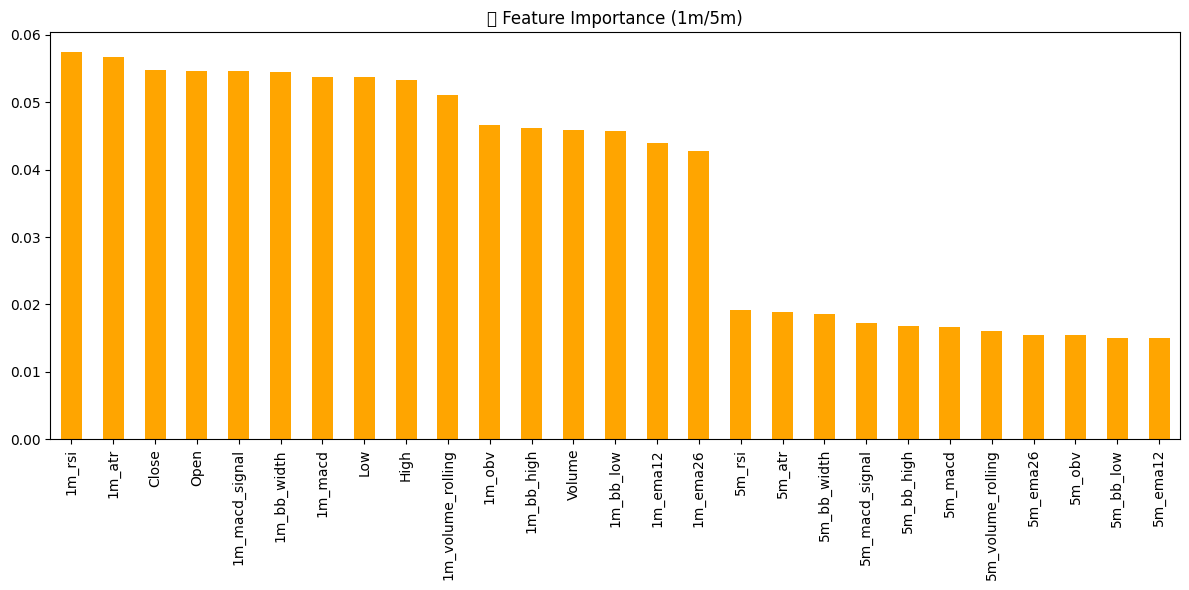

🎯 Новый Fast Report:
              precision    recall  f1-score   support

           0       0.58      0.52      0.55      1089
           1       0.44      0.50      0.47       813

    accuracy                           0.51      1902
   macro avg       0.51      0.51      0.51      1902
weighted avg       0.52      0.51      0.51      1902

📉 Confusion Matrix:
[[565 524]
 [405 408]]
✅ Модель сохранена: rf_model_fast_filtered.pkl


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt

# === Загрузка данных ===
df = pd.read_csv('/content/drive/MyDrive/bot_data/BTC_EUR_fast_features_ready.csv')

# === Убираем лишние поля ===
X = df.drop(columns=["Datetime", "tf", "target"])
y = df["target"]

# === Делим на train/test без перемешивания ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# === Обучаем с балансом классов ===
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# === Смотрим важность признаков ===
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False, inplace=True)

# Вывод топовых признаков
top_feats = importances[importances > 0.01]  # оставим только важные

print("🔥 Важные признаки:")
print(top_feats)

# Визуализация
plt.figure(figsize=(12, 6))
top_feats.plot(kind='bar', color='orange')
plt.title("🔥 Feature Importance (1m/5m)")
plt.tight_layout()
plt.show()

# === Перетренируем модель на отфильтрованных признаках ===
X_top = X[top_feats.index]
X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, shuffle=False)

model_top = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model_top.fit(X_train, y_train)

# === Метрики ===
y_pred = model_top.predict(X_test)
print("🎯 Новый Fast Report:")
print(classification_report(y_test, y_pred))
print("📉 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# === Сохраняем модель ===
joblib.dump(model_top, '/content/drive/MyDrive/bot_data/rf_model_fast_filtered.pkl')
print("✅ Модель сохранена: rf_model_fast_filtered.pkl")


In [ ]:
import pandas as pd

# Загружаем уже сгенерированные фичи
df = pd.read_csv("/content/drive/MyDrive/bot_data/BTC_EUR_fast_features_ready.csv")

# === Новые признаки ===

# Δ между Close и Open (внутрисвечное настроение)
df["delta_close_open"] = df["Close"] - df["Open"]

# RSI - 50 (сильное отклонение от баланса)
df["rsi_diff_50"] = df["1m_rsi"] - 50

# Rolling стандартное отклонение цены (волатильность)
df["rolling_std_close"] = df["Close"].rolling(window=5).std()

# Средний объём за 5 свечей
df["rolling_mean_volume"] = df["Volume"].rolling(window=5).mean()

# Моментум — насколько изменилась цена за N (тут: 5) свечей
df["momentum_5"] = df["Close"].diff(periods=5)

# Очистим пустоты после rolling/shift
df.dropna(inplace=True)

# Сохраняем
df.to_csv("/content/drive/MyDrive/bot_data/BTC_EUR_fast_features_boosted.csv", index=False)
print("🚀 Дополнительные признаки добавлены и сохранены!")


🚀 Дополнительные признаки добавлены и сохранены!


In [ ]:
import pandas as pd

# === Загружаем наши данные с дополнительными признаками ===
df = pd.read_csv("/content/drive/MyDrive/bot_data/BTC_EUR_fast_features_boosted.csv")

# === Создаём целевую переменную ===
df["target"] = (df["Close"].shift(-3) > df["Close"]).astype(int)

# Удалим последние 3 строки, где цель будет NaN
df.dropna(inplace=True)

# === Сохраняем для обучения ===
df.to_csv("/content/drive/MyDrive/bot_data/BTC_EUR_fast_features_boosted_target.csv", index=False)

print("✅ Цель t+3 добавлена. Данных для обучения:", len(df))


✅ Цель t+3 добавлена. Данных для обучения: 9504


📥 Загружено строк: 9504
⚖️ Баланс классов: {np.int64(0): np.float64(0.9722506393861893), np.int64(1): np.float64(1.029379907933929)}
🎯 Classification Report (t+3):
              precision    recall  f1-score   support

           0       0.54      0.71      0.61       989
           1       0.52      0.34      0.41       912

    accuracy                           0.53      1901
   macro avg       0.53      0.53      0.51      1901
weighted avg       0.53      0.53      0.52      1901

📉 Confusion Matrix:
[[704 285]
 [600 312]]
✅ Модель сохранена: rf_model_fast_t3.pkl
🔥 ТОП признаки:
momentum_5             0.052683
rolling_mean_volume    0.051643
rolling_std_close      0.051312
1m_macd_signal         0.045162
1m_obv                 0.044884
1m_bb_width            0.043348
1m_atr                 0.043144
1m_macd                0.042496
1m_volume_rolling      0.041820
Close                  0.041497
High                   0.040267
Low                    0.040077
Open                   0.

<ipython-input-42-3f5e6cc30ed5>:62: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


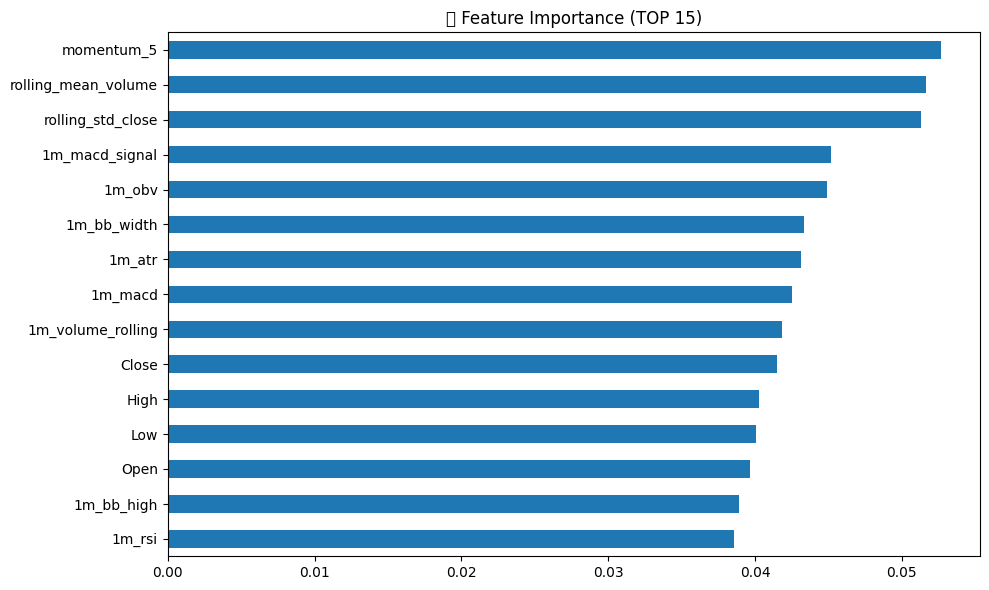

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

# === Настройки ===
DATA_FILE = "/content/drive/MyDrive/bot_data/BTC_EUR_fast_features_boosted_target.csv"
MODEL_NAME = "rf_model_fast_t3.pkl"

# === Загрузка данных ===
df = pd.read_csv(DATA_FILE)
print("📥 Загружено строк:", len(df))

# === Целевое значение ===
y = df["target"]

# === Признаки (без tf, datetime и прочих бесполезных визуальных штук) ===
X = df.drop(columns=["Datetime", "tf", "target"])

# === Разделение на train/test ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# === Баланс классов ===
import numpy as np
classes = np.unique(y_train)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)

class_weights = dict(zip(classes, weights))
print("⚖️ Баланс классов:", class_weights)

# === Обучение ===
model = RandomForestClassifier(n_estimators=150, random_state=42, class_weight=class_weights)
model.fit(X_train, y_train)

# === Предсказания ===
y_pred = model.predict(X_test)

# === Отчёт ===
print("🎯 Classification Report (t+3):")
print(classification_report(y_test, y_pred))
print("📉 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# === Сохранение модели ===
import joblib
joblib.dump(model, f"/content/drive/MyDrive/bot_data/{MODEL_NAME}")
print(f"✅ Модель сохранена: {MODEL_NAME}")

# === Важность признаков ===
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("🔥 ТОП признаки:")
print(importances.head(15))

# === Визуализация ===
plt.figure(figsize=(10, 6))
importances.head(15).plot(kind="barh")
plt.title("🔥 Feature Importance (TOP 15)")
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import ta
import os

# === Настройки ===
INPUT_1M = "/content/drive/MyDrive/bot_data/BTC_EUR_fast_cleaned_1m.csv"
INPUT_5M = "/content/drive/MyDrive/bot_data/BTC_EUR_fast_cleaned_5m.csv"
OUTPUT = "/content/drive/MyDrive/bot_data/BTC_EUR_fast_features_extended.csv"

def add_indicators(df, tf):
    df = df.copy()
    df["Datetime"] = pd.to_datetime(df["Datetime"])
    df = df.sort_values("Datetime")

    # RSI
    df[f"{tf}_rsi"] = ta.momentum.RSIIndicator(close=df["Close"]).rsi()

    # EMA
    df[f"{tf}_ema12"] = ta.trend.EMAIndicator(close=df["Close"], window=12).ema_indicator()
    df[f"{tf}_ema26"] = ta.trend.EMAIndicator(close=df["Close"], window=26).ema_indicator()

    # MACD
    macd = ta.trend.MACD(close=df["Close"])
    df[f"{tf}_macd"] = macd.macd()
    df[f"{tf}_macd_signal"] = macd.macd_signal()

    # Bollinger
    bb = ta.volatility.BollingerBands(close=df["Close"])
    df[f"{tf}_bb_high"] = bb.bollinger_hband()
    df[f"{tf}_bb_low"] = bb.bollinger_lband()
    df[f"{tf}_bb_width"] = bb.bollinger_wband()

    # ATR
    df[f"{tf}_atr"] = ta.volatility.AverageTrueRange(high=df["High"], low=df["Low"], close=df["Close"]).average_true_range()

    # OBV
    df[f"{tf}_obv"] = ta.volume.OnBalanceVolumeIndicator(close=df["Close"], volume=df["Volume"]).on_balance_volume()

    # Volume rolling mean
    df[f"{tf}_volume_rolling"] = df["Volume"].rolling(window=5).mean()

    return df[["Datetime"] + [col for col in df.columns if col.startswith(tf)]]

def process():
    print("📥 Загружаем данные...")
    df_1m = pd.read_csv(INPUT_1M)
    df_5m = pd.read_csv(INPUT_5M)

    # Нормализация названий
    for df in (df_1m, df_5m):
        df.columns = [col.strip() for col in df.columns]
        df["Datetime"] = pd.to_datetime(df["Datetime"])

    # Добавление индикаторов
    print("📊 Вычисляем индикаторы...")
    df_1m_ind = add_indicators(df_1m, "1m")
    df_5m_ind = add_indicators(df_5m, "5m")

    # Объединение по времени
    df = pd.merge(df_1m, df_5m, on="Datetime", suffixes=("", "_drop"))
    df = df[[col for col in df.columns if not col.endswith("_drop")]]

    df = pd.merge(df, df_1m_ind, on="Datetime", how="left")
    df = pd.merge(df, df_5m_ind, on="Datetime", how="left")

    # === Добавим расширенные фичи ===
    print("✨ Добавляем расширенные фичи...")
    df["rsi_diff_50"] = abs(df["1m_rsi"] - 50)
    df["ema_gap"] = df["1m_ema12"] - df["1m_ema26"]
    df["macd_gap"] = df["1m_macd"] - df["1m_macd_signal"]
    df["momentum_5"] = df["Close"].pct_change(periods=5)

    # Кол-во последовательных свечей в одном направлении
    df["direction"] = np.sign(df["Close"].diff())
    df["trend_persistence"] = df["direction"].groupby((df["direction"] != df["direction"].shift()).cumsum()).cumcount() + 1
    df.drop(columns=["direction"], inplace=True)

    # === Обработка пропусков ===
    print("🧹 Чистим и заполняем...")
    ffill_cols = ["Open", "High", "Low", "Close", "Volume"]
    median_cols = [col for col in df.columns if col not in ["Datetime", "tf"] + ffill_cols]

    df[ffill_cols] = df[ffill_cols].ffill()
    df[median_cols] = df[median_cols].fillna(df[median_cols].median())

    # Сохраняем
    print("✅ Сохраняем финальный файл:", OUTPUT)
    df.to_csv(OUTPUT, index=False)
    print("🧮 Всего строк:", len(df))
    print(df.head())

# === Запуск ===
if __name__ == "__main__":
    process()


📥 Загружаем данные...
📊 Вычисляем индикаторы...
✨ Добавляем расширенные фичи...
🧹 Чистим и заполняем...
✅ Сохраняем финальный файл: /content/drive/MyDrive/bot_data/BTC_EUR_fast_features_extended.csv
🧮 Всего строк: 1216
                   Datetime         Close          High           Low  \
0                       NaT           NaN           NaN           NaN   
1 2025-03-31 00:15:00+00:00  75887.742188  75953.976562  75887.742188   
2 2025-03-31 00:30:00+00:00  75721.750000  75721.750000  75721.750000   
3 2025-03-31 01:10:00+00:00  75583.054688  75583.054688  75583.054688   
4 2025-03-31 01:15:00+00:00  75577.164062  75577.164062  75577.164062   

           Open       Volume  tf     1m_rsi      1m_ema12      1m_ema26  ...  \
0           NaN          NaN  1m  26.714892  73215.110986  73463.044903  ...   
1  75953.976562          0.0  1m  49.249590  76195.013321  76196.357910  ...   
2  75721.750000          0.0  1m  21.818180  75832.607661  76196.357910  ...   
3  75583.054688       

In [ ]:
# target_engine_fast.py

import pandas as pd

INPUT_PATH = "/content/drive/MyDrive/bot_data/BTC_EUR_fast_features_extended.csv"
OUTPUT_PATH = "/content/drive/MyDrive/bot_data/BTC_EUR_fast_labeled.csv"

def add_target_t_plus_1(df: pd.DataFrame):
    df = df.copy()
    df['target'] = (df['Close'].shift(-1) > df['Close']).astype(int)
    df.dropna(inplace=True)
    return df

if __name__ == "__main__":
    print("📥 Загружаем данные...")
    df = pd.read_csv(INPUT_PATH)
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    print("✅ Строк до:", len(df))

    df_labeled = add_target_t_plus_1(df)

    print("✅ Строк после:", len(df_labeled))
    df_labeled.to_csv(OUTPUT_PATH, index=False)
    print(f"💾 Сохранено: {OUTPUT_PATH}")


📥 Загружаем данные...
✅ Строк до: 1216
✅ Строк после: 1215
💾 Сохранено: /content/drive/MyDrive/bot_data/BTC_EUR_fast_labeled.csv


⚖️ Баланс классов: {np.int64(0): np.float64(0.9604743083003953), np.int64(1): np.float64(1.0429184549356223)}
🎯 Extended Report:
              precision    recall  f1-score   support

           0       0.62      0.58      0.60       126
           1       0.58      0.62      0.60       117

    accuracy                           0.60       243
   macro avg       0.60      0.60      0.60       243
weighted avg       0.60      0.60      0.60       243

📉 Confusion Matrix:


<ipython-input-45-1753b906cb76>:48: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


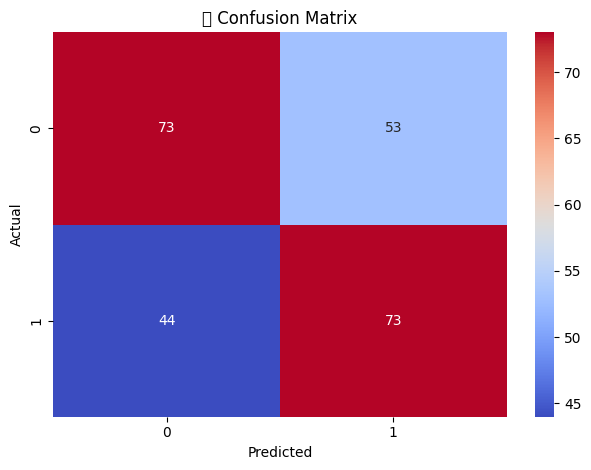

✅ Модель сохранена: /content/drive/MyDrive/bot_data/rf_model_fast_extended.pkl
🔥 ТОП признаки:
5m_rsi               0.083006
rsi_diff_50          0.045433
1m_rsi               0.045263
1m_bb_width          0.039108
momentum_5           0.038866
1m_macd_signal       0.037692
macd_gap             0.037591
1m_obv               0.037401
5m_macd              0.034794
5m_obv               0.034467
1m_volume_rolling    0.033714
5m_bb_width          0.033699
5m_macd_signal       0.033205
ema_gap              0.032987
5m_volume_rolling    0.031627
1m_macd              0.031464
1m_atr               0.030991
5m_atr               0.030477
1m_bb_low            0.028737
Volume               0.023724
dtype: float64


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

DATA_PATH = "/content/drive/MyDrive/bot_data/BTC_EUR_fast_labeled.csv"
MODEL_PATH = "/content/drive/MyDrive/bot_data/rf_model_fast_extended.pkl"

# === Загружаем данные ===
df = pd.read_csv(DATA_PATH)
df['Datetime'] = pd.to_datetime(df['Datetime'])

# === Подготовка признаков ===
X = df.drop(columns=["Datetime", "tf", "target"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# === Баланс классов ===
weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), weights))
print("⚖️ Баланс классов:", class_weights)

# === Модель ===
model = RandomForestClassifier(n_estimators=100, class_weight=class_weights, random_state=42)
model.fit(X_train, y_train)

# === Предсказания ===
y_pred = model.predict(X_test)

# === Отчёт ===
print("🎯 Extended Report:")
print(classification_report(y_test, y_pred))

print("📉 Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("📊 Confusion Matrix")
plt.tight_layout()
plt.show()

# === Сохраняем модель ===
joblib.dump(model, MODEL_PATH)
print(f"✅ Модель сохранена: {MODEL_PATH}")

# === Фичи ===
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("🔥 ТОП признаки:")
print(importances.head(20))


In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

DATA_PATH = "/content/drive/MyDrive/bot_data/BTC_EUR_fast_labeled.csv"

df = pd.read_csv(DATA_PATH)
X = df.drop(columns=["Datetime", "tf", "target"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = lgb.LGBMClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("📊 LightGBM Report:")
print(classification_report(y_test, y_pred))
print("📉 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("🔥 Feature importances:")
print(importances.head(20))

model.booster_.save_model("/content/drive/MyDrive/bot_data/lightgbm_model.txt")


[LightGBM] [Info] Number of positive: 466, number of negative: 506
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7813
[LightGBM] [Info] Number of data points in the train set: 972, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.479424 -> initscore=-0.082351
[LightGBM] [Info] Start training from score -0.082351
📊 LightGBM Report:
              precision    recall  f1-score   support

           0       0.70      0.62      0.66       126
           1       0.63      0.71      0.67       117

    accuracy                           0.66       243
   macro avg       0.67      0.66      0.66       243
weighted avg       0.67      0.66      0.66       243

📉 Confusion Matrix:
[[78 48]
 [34 83]]
🔥 Feature importances:
5m_rsi               361
1m_rsi         

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import joblib

# === Загрузка данных ===
df = pd.read_csv("/content/drive/MyDrive/bot_data/BTC_EUR_fast_labeled.csv")
X = df.drop(columns=["Datetime", "tf", "target"])
y = df["target"]

# === Разделение ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# === Обучение модели ===
model = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.05, use_label_encoder=False, eval_metric="logloss")
model.fit(X_train, y_train)

# === Оценка ===
y_pred = model.predict(X_test)
print("📊 XGBoost Report:")
print(classification_report(y_test, y_pred))
print("📉 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# === Важность признаков ===
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("🔥 Feature importances:")
print(importances.head(20))

# === Сохранение ===
joblib.dump(model, "/content/drive/MyDrive/bot_data/xgb_model_fast.pkl")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:27:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📊 XGBoost Report:
              precision    recall  f1-score   support

           0       0.69      0.71      0.70       126
           1       0.68      0.65      0.66       117

    accuracy                           0.68       243
   macro avg       0.68      0.68      0.68       243
weighted avg       0.68      0.68      0.68       243

📉 Confusion Matrix:
[[90 36]
 [41 76]]
🔥 Feature importances:
1m_macd_signal       0.058577
High                 0.056338
5m_rsi               0.051438
5m_macd              0.045376
5m_bb_low            0.044373
5m_ema26             0.040825
1m_rsi               0.038737
1m_macd              0.037172
Low                  0.036940
5m_bb_high           0.036311
1m_bb_low            0.035862
5m_macd_signal       0.035543
1m_ema12             0.035475
1m_bb_width          0.033271
5m_volume_rolling    0.032199
rsi_diff_50          0.031551
5m_obv               0.030809
5m_ema12             0.030054
5m_bb_width          0.028754
1m_bb_high           0.

['/content/drive/MyDrive/bot_data/xgb_model_fast.pkl']

In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# === Пути ===
DATA_PATH = "/content/drive/MyDrive/bot_data/BTC_EUR_fast_labeled.csv"
MODEL_PATH = "/content/drive/MyDrive/bot_data/lgbm_model_fast.pkl"

# === Загрузка данных ===
print("📥 Загружаем данные...")
df = pd.read_csv(DATA_PATH)
print(f"✅ Всего строк: {len(df)}")

# === Целевой признак ===
y = df["target"]
X = df.drop(columns=["Datetime", "tf", "target"])

# === Разделение на train/test ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# === Модель LightGBM ===
model = lgb.LGBMClassifier(
    learning_rate=0.05,
    num_leaves=31,
    n_estimators=150,
    class_weight='balanced'
)

# === Обучение ===
print("⚙️ Обучаем LightGBM...")
model.fit(X_train, y_train)

# === Оценка ===
print("📊 LightGBM Report:")
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("📉 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# === Сохраняем ===
joblib.dump(model, MODEL_PATH)
print(f"✅ Модель сохранена: {MODEL_PATH}")

# === Важность признаков ===
print("🔥 Feature importances:")
feature_imp = pd.Series(model.feature_importances_, index=X.columns)
print(feature_imp.sort_values(ascending=False).head(20))


📥 Загружаем данные...
✅ Всего строк: 1215
⚙️ Обучаем LightGBM...
[LightGBM] [Info] Number of positive: 466, number of negative: 506
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7813
[LightGBM] [Info] Number of data points in the train set: 972, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
📊 LightGBM Report:
              precision    recall  f1-score   support

           0       0.67      0.65      0.66       126
           1       0.64      0.66      0.65       117

    accuracy                           0.65       243
   macro avg       0.65      0.65      0.65       243
weighted avg       0.65      0.65      0.65       243

📉 Confusion Matrix:
[[82 44]
 [40 77]]
✅ Модель сохранена: /content/drive/MyDrive/bot_data/lgbm_model

In [ ]:
import os

folder_path = "/content/drive/MyDrive/bot_data"
for file in os.listdir(folder_path):
    print(file)


BTC_EUR_features_clean.csv
BTC_EUR_with_target.csv
rf_model.pkl
rf_model_filtered.pkl
BTC_EUR_fast_1m.csv
BTC_EUR_fast_5m.csv
BTC_EUR_fast_cleaned_1m.csv
BTC_EUR_fast_cleaned_5m.csv
BTC_EUR_fast_features_cleaned.csv
BTC_EUR_fast_labeled.csv
BTC_EUR_fast_features_cleaned_filled.csv
BTC_EUR_fast_features_ready.csv
rf_model_fast.pkl
rf_model_fast_filtered.pkl
BTC_EUR_fast_features_boosted.csv
BTC_EUR_fast_features_boosted_target.csv
rf_model_fast_t3.pkl
BTC_EUR_fast_features_extended.csv
rf_model_fast_extended.pkl
lightgbm_model.txt
xgb_model_fast.pkl
lgbm_model_fast.pkl


In [ ]:
from google.colab import files

# Скачиваем датасет с метками
files.download('/content/drive/MyDrive/bot_data/BTC_EUR_fast_labeled.csv')

# Скачиваем модель LightGBM
files.download('/content/drive/MyDrive/bot_data/lgbm_model_fast.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import json

# Сохраняем параметры
params = {
    "model": "LGBMClassifier",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "n_estimators": 150,
    "class_weight": "balanced",
    "target": "t+1 (Close future > Close now)"
}
with open("/content/drive/MyDrive/bot_data/lgbm_model_fast_params.json", "w") as f:
    json.dump(params, f, indent=4)

# Сохраняем список признаков
features = X.columns.tolist()
with open("/content/drive/MyDrive/bot_data/lgbm_model_fast_features.json", "w") as f:
    json.dump(features, f, indent=4)


In [ ]:
import json

# Параметры модели
rf_params = {
    "model": "RandomForestClassifier",
    "n_estimators": 100,
    "max_depth": 6,
    "random_state": 42,
    "class_weight": "balanced",
    "target": "t+1 (Close future > Close now)"
}

with open("/content/drive/MyDrive/bot_data/rf_model_params.json", "w") as f:
    json.dump(rf_params, f, indent=4)

# Список признаков (если X еще в памяти)
features_rf = X.columns.tolist()
with open("/content/drive/MyDrive/bot_data/rf_model_features.json", "w") as f:
    json.dump(features_rf, f, indent=4)


In [ ]:
import json
from google.colab import files

# === 1. Параметры модели (введи сюда свои реальные) ===
model_params = {
    "model": "RandomForestClassifier",
    "n_estimators": 100,
    "max_depth": 6,
    "random_state": 42,
    "class_weight": "balanced",
    "target_logic": "Close_t+1 > Close_t"
}

# === 2. Пути к сохранению ===
params_path = "rf_model_params.json"
features_path = "rf_model_features.json"

# === 3. Список фичей (если у тебя есть X) ===
try:
    feature_list = X.columns.tolist()
except:
    feature_list = ["Close", "High", "Low", "Volume", "1h_rsi", "1h_macd", "1d_bb_width", "...and_others"]
    print("❗ X не найден. Использую примерный список признаков. Заменишь позже.")

# === 4. Сохраняем в JSON ===
with open(params_path, "w") as f:
    json.dump(model_params, f, indent=4)

with open(features_path, "w") as f:
    json.dump(feature_list, f, indent=4)

# === 5. Скачиваем на комп ===
files.download(params_path)
files.download(features_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>